###  Transfer Learning for Facial Emotion Recognition with Face Mask

Transfer Learning is the re-use of pre-trained models on new tasks.
this script is a general implementation of transfer learning in "Pytorch" for any image classification tasks.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! ls


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


In [ ]:
#address of dataset with two folders "train3" and "test3"

%cd /content/drive/MyDrive/Colab_Notebooks/Jaffe_PD/mix3
! ls

/content/drive/MyDrive/Colab_Notebooks/Jaffe_PD/mix3
test3  train3


In [ ]:
!pip install colorama
!pip install ipywidgets
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 KB 23.5 MB/s eta 0:00:00


In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib
import time
import os
import copy

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    ToTensor,
    Resize,
    CenterCrop,
)
from torch.utils.data import DataLoader

# Create datasets
train_data = ImageFolder(
    os.path.join(os.getcwd(), "train3"),
    transform=Compose(
        [RandomResizedCrop(224), RandomHorizontalFlip(), ToTensor()]  # data augmentation
    ),
)

test_data = ImageFolder(
    os.path.join(os.getcwd(), "test3"),
    transform=Compose([Resize(256), CenterCrop(224), ToTensor()]),  # give images the same size as the train images
)

# Specify corresponding batched data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Our datasets have two classes:
class_names = train_data.classes
class_names

['AN', 'DI', 'FE', 'HA', 'NE', 'SA', 'SU']

### Data augmentation

Let's have a look at the effect of the transformations we specified for data augmentation

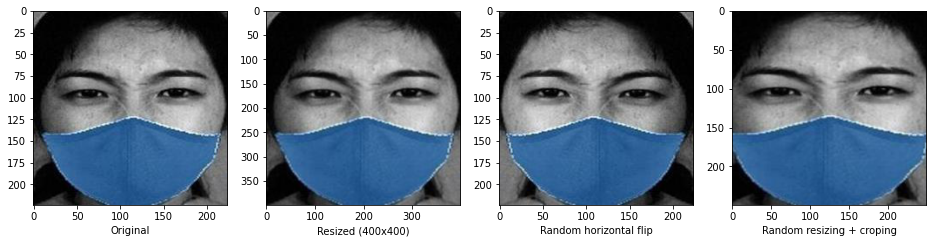

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    Compose,
    RandomResizedCrop,
    RandomHorizontalFlip,
    ToTensor,
    Resize,
    CenterCrop,
)

# Look at one image from the dataset
preview_data = ImageFolder(os.path.join(os.getcwd(), "train3"))
img, label = preview_data[2]

# Let's inspect the effect of the various transformers
fig = plt.figure(figsize=(16, 9))

def show_image(img, label):
    # permute turns (rgb, height, width) into (height, width, rgb)
    plt.imshow(tensor_transformer(img).permute(1, 2, 0))
    plt.xlabel(label)

tensor_transformer = ToTensor()
plt.subplot(1, 4, 1)
show_image(img, "Original")

resize_transformer = Resize(400)
plt.subplot(1, 4, 2)
show_image(resize_transformer(img), "Resized (400x400)")

horizontal_flip_transformer = RandomHorizontalFlip()
plt.subplot(1, 4, 3)
show_image(horizontal_flip_transformer(img), "Random horizontal flip")

random_resize_crop_transformer = RandomResizedCrop(250, scale=(0.5, 1))
plt.subplot(1, 4, 4)
show_image(random_resize_crop_transformer(img), "Random resizing + croping")

### Visualize some training samples

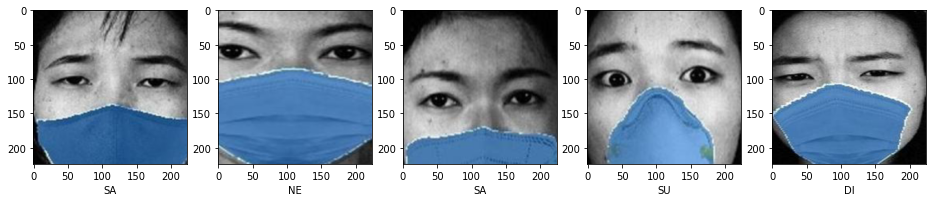

In [ ]:
# Take one batch from the train loader
data, labels = next(iter(train_loader))
data, labels = data[0:5], labels[0:5]

# Plot the images
fig = plt.figure(figsize=(16, 9))
for i in range(0, 5):
    fig.add_subplot(1, 5, i + 1)
    plt.imshow(data[i].permute(1, 2, 0))
    plt.xlabel(class_names[labels[i]])

---

# Loading a pre-trained model

### List of available pre-trained models

`torchvision` includes many pre-trained models. Let's get a list and have a look.

In [ ]:
for model in dir(torchvision.models):
    if model.startswith("_"): continue  
    print(f"- {model}")

- AlexNet
- AlexNet_Weights
- ConvNeXt
- ConvNeXt_Base_Weights
- ConvNeXt_Large_Weights
- ConvNeXt_Small_Weights
- ConvNeXt_Tiny_Weights
- DenseNet
- DenseNet121_Weights
- DenseNet161_Weights
- DenseNet169_Weights
- DenseNet201_Weights
- EfficientNet
- EfficientNet_B0_Weights
- EfficientNet_B1_Weights
- EfficientNet_B2_Weights
- EfficientNet_B3_Weights
- EfficientNet_B4_Weights
- EfficientNet_B5_Weights
- EfficientNet_B6_Weights
- EfficientNet_B7_Weights
- EfficientNet_V2_L_Weights
- EfficientNet_V2_M_Weights
- EfficientNet_V2_S_Weights
- GoogLeNet
- GoogLeNetOutputs
- GoogLeNet_Weights
- Inception3
- InceptionOutputs
- Inception_V3_Weights
- MNASNet
- MNASNet0_5_Weights
- MNASNet0_75_Weights
- MNASNet1_0_Weights
- MNASNet1_3_Weights
- MaxVit
- MaxVit_T_Weights
- MobileNetV2
- MobileNetV3
- MobileNet_V2_Weights
- MobileNet_V3_Large_Weights
- MobileNet_V3_Small_Weights
- RegNet
- RegNet_X_16GF_Weights
- RegNet_X_1_6GF_Weights
- RegNet_X_32GF_Weights
- RegNet_X_3_2GF_Weights
- RegNet_X_4

It's very simple to create a module that has this model with its weights pre-trained for ImageNet.
for example in this implementation we are using ResNet50

In [ ]:
model_ft = torchvision.models.resnet50(pretrained=True)
model_ft

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The last fully connected layer has a 1000 output neurons. It has been trained on ImageNet task which has 1000 image classes.

In [ ]:
model_ft.fc

Linear(in_features=2048, out_features=1000, bias=True)

We would like to perform 7-class emotion classification. Therefore, we have to replace the last fully-connected layer to suit our needs (7 output units).

In [ ]:
model_ft.classifier = nn.Linear(in_features=2048, out_features=7)

In [ ]:
model_ft.classifier

Linear(in_features=2048, out_features=7, bias=True)

---

# Training just the last layer

Freeze all the layers except the last fully-connected one

In [ ]:
for name, param in model_ft.named_parameters():
    if name not in ["fc.weight", "fc.bias"]:
        param.requires_grad = False

In [ ]:
model_ft.requires_grad_(False)
model_ft.fc.requires_grad_(True)

Linear(in_features=2048, out_features=1000, bias=True)

### Define the train and accuracy functions

So, now the architecture contains two output units, we can therefore use it to perform binary classification.

The *train* and _accuracy_ function are almost identical to the functions we used when traininig the CNN. This again nicely demonstrates the modularity of PyTorch and its simple interface.

In [ ]:
import colorama

def train(
    model,
    train_loader,
    test_loader,
    device,
    num_epochs=3,
    learning_rate=0.1,
    decay_learning_rate=False,
):
    # Some models behave differently in training and testing mode (Dropout, BatchNorm)
    # so it is good practice to specify which behavior you want.
    model.train()

    # We will use the Adam with Cross Entropy loss
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()

    if decay_learning_rate:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, 0.85)

    # We make multiple passes over the dataset
    for epoch in range(num_epochs):
        print("=" * 40, "Starting epoch %d" % (epoch + 1), "=" * 40)

        if decay_learning_rate:
            scheduler.step()

        total_epoch_loss = 0.0
        # Make one pass in batches
        for batch_number, (data, labels) in enumerate(train_loader):
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            total_epoch_loss += loss.item()

            if batch_number % 5 == 0:
                print("Batch %d/%d" % (batch_number, len(train_loader)))

        train_acc = accuracy(model, train_loader, device)
        test_acc = accuracy(model, test_loader, device)

        print(
            colorama.Fore.GREEN
            + "\nEpoch %d/%d, Loss=%.4f, Train-Acc=%d%%, Valid-Acc=%d%%"
            % (
                epoch + 1,
                num_epochs,
                total_epoch_loss / len(train_data),
                100 * train_acc,
                100 * test_acc,
            ),
            colorama.Fore.RESET,
        )


In [ ]:
def accuracy(model, data_loader, device):
    model.eval()

    num_correct = 0
    num_samples = 0
    with torch.no_grad():  # deactivates autograd, reduces memory usage and speeds up computations
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            predictions = torch.argmax(model(data), 1)  # find the class number with the largest output
            num_correct += (predictions == labels).sum().item()
            num_samples += len(predictions)

    return num_correct / num_samples

### Launch training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)
# change epochs to 25
train(model_ft, train_loader, test_loader, device, num_epochs=2)

======================================== Starting epoch 1 ========================================
Batch 0/19
Batch 5/19
Batch 10/19
Batch 15/19

Epoch 1/2, Loss=2.7808, Train-Acc=14%, Valid-Acc=14% 
======================================== Starting epoch 2 ========================================
Batch 0/19
Batch 5/19
Batch 10/19
Batch 15/19

Epoch 2/2, Loss=1.9454, Train-Acc=18%, Valid-Acc=21% 


### Inspecting the model's predictions

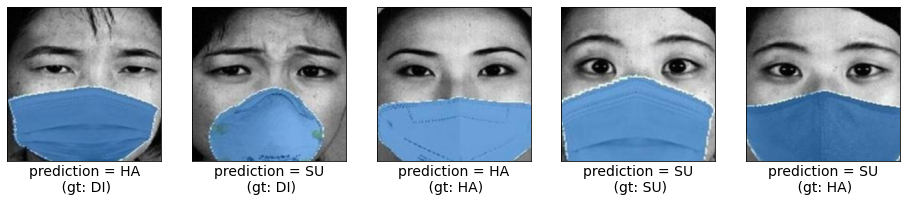

In [ ]:
data, labels = next(iter(DataLoader(test_data, batch_size=5, shuffle=True)))
data, labels = data.to(device), labels
predictions = torch.argmax(model_ft(data), 1).cpu()

predictions, data = predictions.cpu(), data.cpu()  # put it back on CPU for visualization

plt.figure(figsize=(16, 9))
for i in range(5):
    img = data.squeeze(1)[i]
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.xlabel(
        "prediction = %s\n (gt: %s)"
        % (test_data.classes[predictions[i].item()], test_data.classes[labels[i]]),
        fontsize=14,
    )
    plt.xticks([])
    plt.yticks([])

In [ ]:
accuracy(model_ft, test_loader, device)

0.21739130434782608

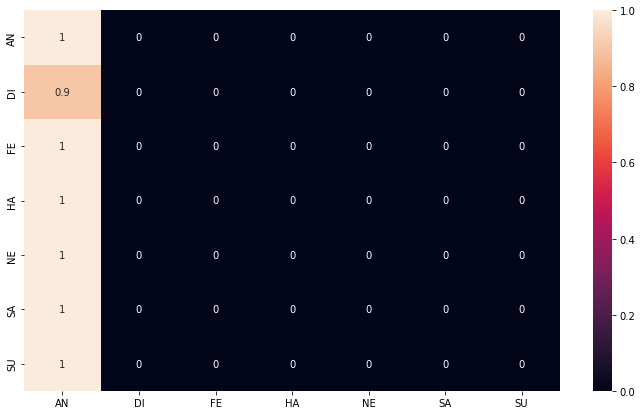

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model_ft(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
#classes = ['alien', 'predator']
classes = class_names
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred,average='micro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred,average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred,average='micro')
print('F1 score: %f' % f1)
# kappa
kappa = cohen_kappa_score(y_true, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#auc = roc_auc_score(y_true, y_pred, average='micro')
#print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_true, y_pred)
print(matrix)

Accuracy: 0.144928
Precision: 0.144928
Recall: 0.144928
F1 score: 0.144928
Cohens kappa: 0.000000
[[40  0  0  0  0  0  0]
 [36  0  0  0  0  0  0]
 [40  0  0  0  0  0  0]
 [40  0  0  0  0  0  0]
 [40  0  0  0  0  0  0]
 [40  0  0  0  0  0  0]
 [40  0  0  0  0  0  0]]
